### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [1]:
#### Import libraries for importing files from Google drive to Colab
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#
## Authorize Google SDK to access Google Drive from Colab
#
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [2]:
###download = drive.CreateFile({'id': '4/1AY0e-g5WtkYpv3UCy9wKEaTwpzJxvzjSuIpyQCBYfJ63VmZfHViXt9HSlN0'})
###download.GetContentFile('ptb.train.txt')

In [3]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pwd
!ls -al
%cd '/content/gdrive/My Drive/NLP/Part2/D015_推論方法的詞向量_實作加速版 word2vec_作業檔'
!ls -al

/content
total 20
drwxr-xr-x 1 root root 4096 Mar 15 01:30 .
drwxr-xr-x 1 root root 4096 Mar 15 01:27 ..
drwxr-xr-x 4 root root 4096 Mar  5 14:36 .config
drwx------ 5 root root 4096 Mar 15 01:30 gdrive
drwxr-xr-x 1 root root 4096 Mar  5 14:37 sample_data
/content/gdrive/My Drive/NLP/Part2/D015_推論方法的詞向量_實作加速版 word2vec_作業檔
total 5591
-rw------- 1 root root 5101618 Nov 21 21:01 ptb.train.txt
-rw------- 1 root root  622886 Mar 15 01:29 word2vec高速化_作業.ipynb


### Import Necessary Libraries

In [5]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
# 讀取資料

# Penn Tree Back dataset
with open("./ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [7]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [8]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            # hint: 請計算字詞頻率
        
            ### <your code> ###
            
            #字詞轉換成小寫 
            sentence = str(sentence).lower()

            if self.only_word: #僅保留字母，其於過濾掉
              sentence = [word for word in re.findall(r"[a-zA-Z]*", sentence) if word != ""]
            else:        #分割保留標點符號
              for p in ['.', ',', '!', '?']:
                sentence = sentence.replace(p, ' '+p)
              #分割字詞
              sentence = sentence.split(' ')
            
            # 計算字詞數量頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict( filter(lambda x: x[1]>self.min_freq, counter.items()) )

        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus =[[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            ### <your code> ###
            self.processed_corpus = [[idx for idx in line if self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")
        
        # hint: 移除空字串
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line)!=0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        
        ### <your code> ###
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 888326 words
After subsampling: 434181 words


### 定義Skip-gram使用的Dataset與collate function

In [9]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        ### <your code> ###
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx]) ### <your code> ###

        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文 (考慮window_size)
            ### <your code> ###
            all_targets += [[word] for word in line[self.window_size:-self.window_size]]
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                ### <your code> ###
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_contexts.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        
        cur_exists_words = list(self.word2freq.keys()) ### <your code> ###
        sampling_weights = [self.word2freq[word]**0.75 for word in self.word2freq] ### <your code> ###
        population = list(range(len(sampling_weights))) ### <your code> ###
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for word in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=int(1e5))
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                if neg_candidate[i] != word[0]:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives)       
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

In [10]:
#查看資料產出
d_set = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=1, num_negatives=3)
dataloader = DataLoader(d_set, batch_size=2, shuffle=True, collate_fn=skipgram_collate)

#透過next與iter取出資料
next(iter(dataloader))

(tensor([[   4,  411],
         [1259,  672]]), tensor([[ 872, 5845, 4239, 1061],
         [ 482,  172,  215,  212]]), tensor([[1, 0, 0, 0],
         [1, 0, 0, 0]]))

### 定義Skip-gram模型

In [11]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size) ### <your code> ###
        self.out_embedding = nn.Embedding(vocab_size, embed_size) ### <your code> ###
        
    def forward(self, contexts, targets):
        v = torch.mean(self.in_embedding(contexts), dim=1) ### <your code> ###
        u = self.out_embedding(targets) ### <your code> ###
        
        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1)) ### <your code> ###
        
        return pred.squeeze(dim=1)

### 訓練

In [14]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 30
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduce='mean') ### <your code> ###
optimizer = optim.Adam(model.parameters(), lr=lr) ### <your code> ### #學員可以自行選用optimizer
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=2, num_negatives=5) ### <your code> ###
loader = DataLoader(d_set, batch_size=2, shuffle=True, collate_fn=skipgram_collate)  ### <your code> ###

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [15]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        
        ### <your code> ###
        optimizer.zero_grad()

        if use_cuda:
            ### <your code> ###
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()

        pred = model(contexts, target_negative) ### <your code> ###
        loss = criterion(pred.float(), labels.float()) ### <your code> ###
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30, Batch: 501/531.900390625 Loss: 2.90632
Epoch: 1/30, Batch: 1001/531.900390625 Loss: 2.91597
Epoch: 1/30, Batch: 1501/531.900390625 Loss: 2.90758
Epoch: 1/30, Batch: 2001/531.900390625 Loss: 2.94068
Epoch: 1/30, Batch: 2501/531.900390625 Loss: 2.94563
Epoch: 1/30, Batch: 3001/531.900390625 Loss: 2.95368
Epoch: 1/30, Batch: 3501/531.900390625 Loss: 2.97813
Epoch: 1/30, Batch: 4001/531.900390625 Loss: 2.99859
Epoch: 1/30, Batch: 4501/531.900390625 Loss: 2.99277
Epoch: 1/30, Batch: 5001/531.900390625 Loss: 2.99928
Epoch: 1/30, Batch: 5501/531.900390625 Loss: 3.00806
Epoch: 1/30, Batch: 6001/531.900390625 Loss: 3.00923
Epoch: 1/30, Batch: 6501/531.900390625 Loss: 3.00424
Epoch: 1/30, Batch: 7001/531.900390625 Loss: 3.00280
Epoch: 1/30, Batch: 7501/531.900390625 Loss: 3.00376
Epoch: 1/30, Batch: 8001/531.900390625 Loss: 2.99674
Epoch: 1/30, Batch: 8501/531.900390625 Loss: 2.99216
Epoch: 1/30, Batch: 9001/531.900390625 Loss: 2.99817
Epoch: 1/30, Batch: 9501/531.900390625 Loss: 2.


  3%|▎         | 1/30 [04:28<2:09:46, 268.50s/it]

Epoch: 1/30, Loss: 3.20943
Epoch: 2/30, Batch: 501/531.900390625 Loss: 2.10638
Epoch: 2/30, Batch: 1001/531.900390625 Loss: 2.24213
Epoch: 2/30, Batch: 1501/531.900390625 Loss: 2.18849
Epoch: 2/30, Batch: 2001/531.900390625 Loss: 2.17953
Epoch: 2/30, Batch: 2501/531.900390625 Loss: 2.16974
Epoch: 2/30, Batch: 3001/531.900390625 Loss: 2.19058
Epoch: 2/30, Batch: 3501/531.900390625 Loss: 2.17163
Epoch: 2/30, Batch: 4001/531.900390625 Loss: 2.17385
Epoch: 2/30, Batch: 4501/531.900390625 Loss: 2.19498
Epoch: 2/30, Batch: 5001/531.900390625 Loss: 2.19535
Epoch: 2/30, Batch: 5501/531.900390625 Loss: 2.18013
Epoch: 2/30, Batch: 6001/531.900390625 Loss: 2.18191
Epoch: 2/30, Batch: 6501/531.900390625 Loss: 2.18192
Epoch: 2/30, Batch: 7001/531.900390625 Loss: 2.16894
Epoch: 2/30, Batch: 7501/531.900390625 Loss: 2.16571
Epoch: 2/30, Batch: 8001/531.900390625 Loss: 2.16916
Epoch: 2/30, Batch: 8501/531.900390625 Loss: 2.17857
Epoch: 2/30, Batch: 9001/531.900390625 Loss: 2.18673
Epoch: 2/30, Batch: 


  7%|▋         | 2/30 [08:56<2:05:15, 268.41s/it]

Epoch: 2/30, Loss: 3.10990
Epoch: 3/30, Batch: 501/531.900390625 Loss: 1.90575
Epoch: 3/30, Batch: 1001/531.900390625 Loss: 2.03311
Epoch: 3/30, Batch: 1501/531.900390625 Loss: 2.03032
Epoch: 3/30, Batch: 2001/531.900390625 Loss: 2.04651
Epoch: 3/30, Batch: 2501/531.900390625 Loss: 2.00155
Epoch: 3/30, Batch: 3001/531.900390625 Loss: 2.03376
Epoch: 3/30, Batch: 3501/531.900390625 Loss: 2.04299
Epoch: 3/30, Batch: 4001/531.900390625 Loss: 2.03992
Epoch: 3/30, Batch: 4501/531.900390625 Loss: 2.05183
Epoch: 3/30, Batch: 5001/531.900390625 Loss: 2.07084
Epoch: 3/30, Batch: 5501/531.900390625 Loss: 2.06750
Epoch: 3/30, Batch: 6001/531.900390625 Loss: 2.09528
Epoch: 3/30, Batch: 6501/531.900390625 Loss: 2.09235
Epoch: 3/30, Batch: 7001/531.900390625 Loss: 2.09315
Epoch: 3/30, Batch: 7501/531.900390625 Loss: 2.10352
Epoch: 3/30, Batch: 8001/531.900390625 Loss: 2.10662
Epoch: 3/30, Batch: 8501/531.900390625 Loss: 2.10749
Epoch: 3/30, Batch: 9001/531.900390625 Loss: 2.10411
Epoch: 3/30, Batch: 


 10%|█         | 3/30 [13:24<2:00:44, 268.31s/it]

Epoch: 3/30, Loss: 2.98370
Epoch: 4/30, Batch: 501/531.900390625 Loss: 1.74919
Epoch: 4/30, Batch: 1001/531.900390625 Loss: 1.80600
Epoch: 4/30, Batch: 1501/531.900390625 Loss: 1.86429
Epoch: 4/30, Batch: 2001/531.900390625 Loss: 1.85076
Epoch: 4/30, Batch: 2501/531.900390625 Loss: 1.88213
Epoch: 4/30, Batch: 3001/531.900390625 Loss: 1.90517
Epoch: 4/30, Batch: 3501/531.900390625 Loss: 1.91240
Epoch: 4/30, Batch: 4001/531.900390625 Loss: 1.92164
Epoch: 4/30, Batch: 4501/531.900390625 Loss: 1.91504
Epoch: 4/30, Batch: 5001/531.900390625 Loss: 1.91411
Epoch: 4/30, Batch: 5501/531.900390625 Loss: 1.92195
Epoch: 4/30, Batch: 6001/531.900390625 Loss: 1.94018
Epoch: 4/30, Batch: 6501/531.900390625 Loss: 1.96644
Epoch: 4/30, Batch: 7001/531.900390625 Loss: 1.96405
Epoch: 4/30, Batch: 7501/531.900390625 Loss: 1.96959
Epoch: 4/30, Batch: 8001/531.900390625 Loss: 1.97480
Epoch: 4/30, Batch: 8501/531.900390625 Loss: 1.97296
Epoch: 4/30, Batch: 9001/531.900390625 Loss: 1.97714
Epoch: 4/30, Batch: 


 13%|█▎        | 4/30 [17:52<1:56:15, 268.27s/it]

Epoch: 4/30, Loss: 2.84769
Epoch: 5/30, Batch: 501/531.900390625 Loss: 1.81465
Epoch: 5/30, Batch: 1001/531.900390625 Loss: 1.84825
Epoch: 5/30, Batch: 1501/531.900390625 Loss: 1.86716
Epoch: 5/30, Batch: 2001/531.900390625 Loss: 1.81706
Epoch: 5/30, Batch: 2501/531.900390625 Loss: 1.78315
Epoch: 5/30, Batch: 3001/531.900390625 Loss: 1.78875
Epoch: 5/30, Batch: 3501/531.900390625 Loss: 1.79968
Epoch: 5/30, Batch: 4001/531.900390625 Loss: 1.81268
Epoch: 5/30, Batch: 4501/531.900390625 Loss: 1.82374
Epoch: 5/30, Batch: 5001/531.900390625 Loss: 1.83973
Epoch: 5/30, Batch: 5501/531.900390625 Loss: 1.84436
Epoch: 5/30, Batch: 6001/531.900390625 Loss: 1.85196
Epoch: 5/30, Batch: 6501/531.900390625 Loss: 1.85763
Epoch: 5/30, Batch: 7001/531.900390625 Loss: 1.86187
Epoch: 5/30, Batch: 7501/531.900390625 Loss: 1.86419
Epoch: 5/30, Batch: 8001/531.900390625 Loss: 1.87165
Epoch: 5/30, Batch: 8501/531.900390625 Loss: 1.87061
Epoch: 5/30, Batch: 9001/531.900390625 Loss: 1.86540
Epoch: 5/30, Batch: 


 17%|█▋        | 5/30 [22:21<1:51:45, 268.22s/it]

Epoch: 5/30, Loss: 2.70824
Epoch: 6/30, Batch: 501/531.900390625 Loss: 1.59359
Epoch: 6/30, Batch: 1001/531.900390625 Loss: 1.65715
Epoch: 6/30, Batch: 1501/531.900390625 Loss: 1.66788
Epoch: 6/30, Batch: 2001/531.900390625 Loss: 1.68976
Epoch: 6/30, Batch: 2501/531.900390625 Loss: 1.68966
Epoch: 6/30, Batch: 3001/531.900390625 Loss: 1.69539
Epoch: 6/30, Batch: 3501/531.900390625 Loss: 1.72777
Epoch: 6/30, Batch: 4001/531.900390625 Loss: 1.70711
Epoch: 6/30, Batch: 4501/531.900390625 Loss: 1.71005
Epoch: 6/30, Batch: 5001/531.900390625 Loss: 1.70463
Epoch: 6/30, Batch: 5501/531.900390625 Loss: 1.72024
Epoch: 6/30, Batch: 6001/531.900390625 Loss: 1.71861
Epoch: 6/30, Batch: 6501/531.900390625 Loss: 1.72320
Epoch: 6/30, Batch: 7001/531.900390625 Loss: 1.72875
Epoch: 6/30, Batch: 7501/531.900390625 Loss: 1.74061
Epoch: 6/30, Batch: 8001/531.900390625 Loss: 1.73830
Epoch: 6/30, Batch: 8501/531.900390625 Loss: 1.74446
Epoch: 6/30, Batch: 9001/531.900390625 Loss: 1.75264
Epoch: 6/30, Batch: 


 20%|██        | 6/30 [26:48<1:47:14, 268.11s/it]

Epoch: 6/30, Loss: 2.56170
Epoch: 7/30, Batch: 501/531.900390625 Loss: 1.51720
Epoch: 7/30, Batch: 1001/531.900390625 Loss: 1.57633
Epoch: 7/30, Batch: 1501/531.900390625 Loss: 1.58038
Epoch: 7/30, Batch: 2001/531.900390625 Loss: 1.56472
Epoch: 7/30, Batch: 2501/531.900390625 Loss: 1.57897
Epoch: 7/30, Batch: 3001/531.900390625 Loss: 1.60555
Epoch: 7/30, Batch: 3501/531.900390625 Loss: 1.63008
Epoch: 7/30, Batch: 4001/531.900390625 Loss: 1.63912
Epoch: 7/30, Batch: 4501/531.900390625 Loss: 1.64272
Epoch: 7/30, Batch: 5001/531.900390625 Loss: 1.64945
Epoch: 7/30, Batch: 5501/531.900390625 Loss: 1.63861
Epoch: 7/30, Batch: 6001/531.900390625 Loss: 1.63280
Epoch: 7/30, Batch: 6501/531.900390625 Loss: 1.65020
Epoch: 7/30, Batch: 7001/531.900390625 Loss: 1.63952
Epoch: 7/30, Batch: 7501/531.900390625 Loss: 1.65782
Epoch: 7/30, Batch: 8001/531.900390625 Loss: 1.66001
Epoch: 7/30, Batch: 8501/531.900390625 Loss: 1.66397
Epoch: 7/30, Batch: 9001/531.900390625 Loss: 1.66078
Epoch: 7/30, Batch: 


 23%|██▎       | 7/30 [31:16<1:42:45, 268.08s/it]

Epoch: 7/30, Loss: 2.44652
Epoch: 8/30, Batch: 501/531.900390625 Loss: 1.37435
Epoch: 8/30, Batch: 1001/531.900390625 Loss: 1.41264
Epoch: 8/30, Batch: 1501/531.900390625 Loss: 1.43626
Epoch: 8/30, Batch: 2001/531.900390625 Loss: 1.48289
Epoch: 8/30, Batch: 2501/531.900390625 Loss: 1.48453
Epoch: 8/30, Batch: 3001/531.900390625 Loss: 1.52114
Epoch: 8/30, Batch: 3501/531.900390625 Loss: 1.54848
Epoch: 8/30, Batch: 4001/531.900390625 Loss: 1.55919
Epoch: 8/30, Batch: 4501/531.900390625 Loss: 1.58030
Epoch: 8/30, Batch: 5001/531.900390625 Loss: 1.59777
Epoch: 8/30, Batch: 5501/531.900390625 Loss: 1.61205
Epoch: 8/30, Batch: 6001/531.900390625 Loss: 1.61249
Epoch: 8/30, Batch: 6501/531.900390625 Loss: 1.59364
Epoch: 8/30, Batch: 7001/531.900390625 Loss: 1.60587
Epoch: 8/30, Batch: 7501/531.900390625 Loss: 1.59415
Epoch: 8/30, Batch: 8001/531.900390625 Loss: 1.59983
Epoch: 8/30, Batch: 8501/531.900390625 Loss: 1.59373
Epoch: 8/30, Batch: 9001/531.900390625 Loss: 1.59160
Epoch: 8/30, Batch: 


 27%|██▋       | 8/30 [35:44<1:38:17, 268.08s/it]

Epoch: 8/30, Loss: 2.32662
Epoch: 9/30, Batch: 501/531.900390625 Loss: 1.50384
Epoch: 9/30, Batch: 1001/531.900390625 Loss: 1.46763
Epoch: 9/30, Batch: 1501/531.900390625 Loss: 1.47825
Epoch: 9/30, Batch: 2001/531.900390625 Loss: 1.47408
Epoch: 9/30, Batch: 2501/531.900390625 Loss: 1.48724
Epoch: 9/30, Batch: 3001/531.900390625 Loss: 1.50343
Epoch: 9/30, Batch: 3501/531.900390625 Loss: 1.46230
Epoch: 9/30, Batch: 4001/531.900390625 Loss: 1.45714
Epoch: 9/30, Batch: 4501/531.900390625 Loss: 1.43324
Epoch: 9/30, Batch: 5001/531.900390625 Loss: 1.42889
Epoch: 9/30, Batch: 5501/531.900390625 Loss: 1.43794
Epoch: 9/30, Batch: 6001/531.900390625 Loss: 1.43645
Epoch: 9/30, Batch: 6501/531.900390625 Loss: 1.44478
Epoch: 9/30, Batch: 7001/531.900390625 Loss: 1.44583
Epoch: 9/30, Batch: 7501/531.900390625 Loss: 1.45854
Epoch: 9/30, Batch: 8001/531.900390625 Loss: 1.46327
Epoch: 9/30, Batch: 8501/531.900390625 Loss: 1.46405
Epoch: 9/30, Batch: 9001/531.900390625 Loss: 1.47142
Epoch: 9/30, Batch: 


 30%|███       | 9/30 [40:12<1:33:48, 268.04s/it]

Epoch: 9/30, Loss: 2.20823
Epoch: 10/30, Batch: 501/531.900390625 Loss: 1.47865
Epoch: 10/30, Batch: 1001/531.900390625 Loss: 1.41568
Epoch: 10/30, Batch: 1501/531.900390625 Loss: 1.40088
Epoch: 10/30, Batch: 2001/531.900390625 Loss: 1.41333
Epoch: 10/30, Batch: 2501/531.900390625 Loss: 1.40135
Epoch: 10/30, Batch: 3001/531.900390625 Loss: 1.40713
Epoch: 10/30, Batch: 3501/531.900390625 Loss: 1.36957
Epoch: 10/30, Batch: 4001/531.900390625 Loss: 1.37379
Epoch: 10/30, Batch: 4501/531.900390625 Loss: 1.38695
Epoch: 10/30, Batch: 5001/531.900390625 Loss: 1.38117
Epoch: 10/30, Batch: 5501/531.900390625 Loss: 1.38899
Epoch: 10/30, Batch: 6001/531.900390625 Loss: 1.40382
Epoch: 10/30, Batch: 6501/531.900390625 Loss: 1.40974
Epoch: 10/30, Batch: 7001/531.900390625 Loss: 1.41100
Epoch: 10/30, Batch: 7501/531.900390625 Loss: 1.40725
Epoch: 10/30, Batch: 8001/531.900390625 Loss: 1.42249
Epoch: 10/30, Batch: 8501/531.900390625 Loss: 1.42592
Epoch: 10/30, Batch: 9001/531.900390625 Loss: 1.43005
Ep


 33%|███▎      | 10/30 [44:40<1:29:18, 267.94s/it]

Epoch: 10/30, Loss: 2.10656
Epoch: 11/30, Batch: 501/531.900390625 Loss: 1.31184
Epoch: 11/30, Batch: 1001/531.900390625 Loss: 1.36917
Epoch: 11/30, Batch: 1501/531.900390625 Loss: 1.30501
Epoch: 11/30, Batch: 2001/531.900390625 Loss: 1.27854
Epoch: 11/30, Batch: 2501/531.900390625 Loss: 1.27468
Epoch: 11/30, Batch: 3001/531.900390625 Loss: 1.28692
Epoch: 11/30, Batch: 3501/531.900390625 Loss: 1.28883
Epoch: 11/30, Batch: 4001/531.900390625 Loss: 1.27180
Epoch: 11/30, Batch: 4501/531.900390625 Loss: 1.28111
Epoch: 11/30, Batch: 5001/531.900390625 Loss: 1.28164
Epoch: 11/30, Batch: 5501/531.900390625 Loss: 1.28785
Epoch: 11/30, Batch: 6001/531.900390625 Loss: 1.28917
Epoch: 11/30, Batch: 6501/531.900390625 Loss: 1.29236
Epoch: 11/30, Batch: 7001/531.900390625 Loss: 1.29076
Epoch: 11/30, Batch: 7501/531.900390625 Loss: 1.29924
Epoch: 11/30, Batch: 8001/531.900390625 Loss: 1.29497
Epoch: 11/30, Batch: 8501/531.900390625 Loss: 1.30485
Epoch: 11/30, Batch: 9001/531.900390625 Loss: 1.31153
E


 37%|███▋      | 11/30 [49:08<1:24:49, 267.87s/it]

Epoch: 11/30, Loss: 2.01327
Epoch: 12/30, Batch: 501/531.900390625 Loss: 1.02390
Epoch: 12/30, Batch: 1001/531.900390625 Loss: 1.12953
Epoch: 12/30, Batch: 1501/531.900390625 Loss: 1.15219
Epoch: 12/30, Batch: 2001/531.900390625 Loss: 1.17780
Epoch: 12/30, Batch: 2501/531.900390625 Loss: 1.19512
Epoch: 12/30, Batch: 3001/531.900390625 Loss: 1.20474
Epoch: 12/30, Batch: 3501/531.900390625 Loss: 1.21415
Epoch: 12/30, Batch: 4001/531.900390625 Loss: 1.20955
Epoch: 12/30, Batch: 4501/531.900390625 Loss: 1.21387
Epoch: 12/30, Batch: 5001/531.900390625 Loss: 1.22020
Epoch: 12/30, Batch: 5501/531.900390625 Loss: 1.21556
Epoch: 12/30, Batch: 6001/531.900390625 Loss: 1.21300
Epoch: 12/30, Batch: 6501/531.900390625 Loss: 1.22997
Epoch: 12/30, Batch: 7001/531.900390625 Loss: 1.23200
Epoch: 12/30, Batch: 7501/531.900390625 Loss: 1.24322
Epoch: 12/30, Batch: 8001/531.900390625 Loss: 1.24886
Epoch: 12/30, Batch: 8501/531.900390625 Loss: 1.25812
Epoch: 12/30, Batch: 9001/531.900390625 Loss: 1.25710
E


 40%|████      | 12/30 [53:36<1:20:20, 267.83s/it]

Epoch: 12/30, Loss: 1.91783
Epoch: 13/30, Batch: 501/531.900390625 Loss: 1.32068
Epoch: 13/30, Batch: 1001/531.900390625 Loss: 1.28190
Epoch: 13/30, Batch: 1501/531.900390625 Loss: 1.21022
Epoch: 13/30, Batch: 2001/531.900390625 Loss: 1.19834
Epoch: 13/30, Batch: 2501/531.900390625 Loss: 1.20587
Epoch: 13/30, Batch: 3001/531.900390625 Loss: 1.21698
Epoch: 13/30, Batch: 3501/531.900390625 Loss: 1.22240
Epoch: 13/30, Batch: 4001/531.900390625 Loss: 1.22711
Epoch: 13/30, Batch: 4501/531.900390625 Loss: 1.23670
Epoch: 13/30, Batch: 5001/531.900390625 Loss: 1.23923
Epoch: 13/30, Batch: 5501/531.900390625 Loss: 1.22990
Epoch: 13/30, Batch: 6001/531.900390625 Loss: 1.24135
Epoch: 13/30, Batch: 6501/531.900390625 Loss: 1.22810
Epoch: 13/30, Batch: 7001/531.900390625 Loss: 1.22782
Epoch: 13/30, Batch: 7501/531.900390625 Loss: 1.23365
Epoch: 13/30, Batch: 8001/531.900390625 Loss: 1.23358
Epoch: 13/30, Batch: 8501/531.900390625 Loss: 1.22163
Epoch: 13/30, Batch: 9001/531.900390625 Loss: 1.21140
E


 43%|████▎     | 13/30 [58:03<1:15:52, 267.79s/it]

Epoch: 13/30, Loss: 1.84905
Epoch: 14/30, Batch: 501/531.900390625 Loss: 1.03135
Epoch: 14/30, Batch: 1001/531.900390625 Loss: 1.09689
Epoch: 14/30, Batch: 1501/531.900390625 Loss: 1.14080
Epoch: 14/30, Batch: 2001/531.900390625 Loss: 1.16713
Epoch: 14/30, Batch: 2501/531.900390625 Loss: 1.19660
Epoch: 14/30, Batch: 3001/531.900390625 Loss: 1.19611
Epoch: 14/30, Batch: 3501/531.900390625 Loss: 1.21137
Epoch: 14/30, Batch: 4001/531.900390625 Loss: 1.18634
Epoch: 14/30, Batch: 4501/531.900390625 Loss: 1.18542
Epoch: 14/30, Batch: 5001/531.900390625 Loss: 1.19182
Epoch: 14/30, Batch: 5501/531.900390625 Loss: 1.19220
Epoch: 14/30, Batch: 6001/531.900390625 Loss: 1.20047
Epoch: 14/30, Batch: 6501/531.900390625 Loss: 1.19891
Epoch: 14/30, Batch: 7001/531.900390625 Loss: 1.20315
Epoch: 14/30, Batch: 7501/531.900390625 Loss: 1.21704
Epoch: 14/30, Batch: 8001/531.900390625 Loss: 1.22643
Epoch: 14/30, Batch: 8501/531.900390625 Loss: 1.22127
Epoch: 14/30, Batch: 9001/531.900390625 Loss: 1.21209
E


 47%|████▋     | 14/30 [1:02:31<1:11:24, 267.80s/it]

Epoch: 14/30, Loss: 1.75584
Epoch: 15/30, Batch: 501/531.900390625 Loss: 0.91087
Epoch: 15/30, Batch: 1001/531.900390625 Loss: 1.04249
Epoch: 15/30, Batch: 1501/531.900390625 Loss: 1.06323
Epoch: 15/30, Batch: 2001/531.900390625 Loss: 1.07475
Epoch: 15/30, Batch: 2501/531.900390625 Loss: 1.10421
Epoch: 15/30, Batch: 3001/531.900390625 Loss: 1.11966
Epoch: 15/30, Batch: 3501/531.900390625 Loss: 1.14509
Epoch: 15/30, Batch: 4001/531.900390625 Loss: 1.15917
Epoch: 15/30, Batch: 4501/531.900390625 Loss: 1.16208
Epoch: 15/30, Batch: 5001/531.900390625 Loss: 1.14337
Epoch: 15/30, Batch: 5501/531.900390625 Loss: 1.14796
Epoch: 15/30, Batch: 6001/531.900390625 Loss: 1.15734
Epoch: 15/30, Batch: 6501/531.900390625 Loss: 1.15581
Epoch: 15/30, Batch: 7001/531.900390625 Loss: 1.14437
Epoch: 15/30, Batch: 7501/531.900390625 Loss: 1.14311
Epoch: 15/30, Batch: 8001/531.900390625 Loss: 1.13442
Epoch: 15/30, Batch: 8501/531.900390625 Loss: 1.14356
Epoch: 15/30, Batch: 9001/531.900390625 Loss: 1.14085
E


 50%|█████     | 15/30 [1:06:59<1:06:57, 267.84s/it]

Epoch: 15/30, Loss: 1.69088
Epoch: 16/30, Batch: 501/531.900390625 Loss: 1.02071
Epoch: 16/30, Batch: 1001/531.900390625 Loss: 1.00667
Epoch: 16/30, Batch: 1501/531.900390625 Loss: 1.03139
Epoch: 16/30, Batch: 2001/531.900390625 Loss: 1.06546
Epoch: 16/30, Batch: 2501/531.900390625 Loss: 1.06099
Epoch: 16/30, Batch: 3001/531.900390625 Loss: 1.08785
Epoch: 16/30, Batch: 3501/531.900390625 Loss: 1.08310
Epoch: 16/30, Batch: 4001/531.900390625 Loss: 1.05955
Epoch: 16/30, Batch: 4501/531.900390625 Loss: 1.04930
Epoch: 16/30, Batch: 5001/531.900390625 Loss: 1.05824
Epoch: 16/30, Batch: 5501/531.900390625 Loss: 1.05834
Epoch: 16/30, Batch: 6001/531.900390625 Loss: 1.06395
Epoch: 16/30, Batch: 6501/531.900390625 Loss: 1.07043
Epoch: 16/30, Batch: 7001/531.900390625 Loss: 1.06519
Epoch: 16/30, Batch: 7501/531.900390625 Loss: 1.07676
Epoch: 16/30, Batch: 8001/531.900390625 Loss: 1.08341
Epoch: 16/30, Batch: 8501/531.900390625 Loss: 1.08148
Epoch: 16/30, Batch: 9001/531.900390625 Loss: 1.08686
E


 53%|█████▎    | 16/30 [1:11:27<1:02:31, 267.97s/it]

Epoch: 16/30, Loss: 1.62557
Epoch: 17/30, Batch: 501/531.900390625 Loss: 1.03644
Epoch: 17/30, Batch: 1001/531.900390625 Loss: 1.01697
Epoch: 17/30, Batch: 1501/531.900390625 Loss: 0.99068
Epoch: 17/30, Batch: 2001/531.900390625 Loss: 1.02551
Epoch: 17/30, Batch: 2501/531.900390625 Loss: 1.00881
Epoch: 17/30, Batch: 3001/531.900390625 Loss: 1.02148
Epoch: 17/30, Batch: 3501/531.900390625 Loss: 1.03572
Epoch: 17/30, Batch: 4001/531.900390625 Loss: 1.04746
Epoch: 17/30, Batch: 4501/531.900390625 Loss: 1.03516
Epoch: 17/30, Batch: 5001/531.900390625 Loss: 1.03359
Epoch: 17/30, Batch: 5501/531.900390625 Loss: 1.04631
Epoch: 17/30, Batch: 6001/531.900390625 Loss: 1.05461
Epoch: 17/30, Batch: 6501/531.900390625 Loss: 1.05066
Epoch: 17/30, Batch: 7001/531.900390625 Loss: 1.05517
Epoch: 17/30, Batch: 7501/531.900390625 Loss: 1.04376
Epoch: 17/30, Batch: 8001/531.900390625 Loss: 1.04224
Epoch: 17/30, Batch: 8501/531.900390625 Loss: 1.03936
Epoch: 17/30, Batch: 9001/531.900390625 Loss: 1.05066
E


 57%|█████▋    | 17/30 [1:15:55<58:04, 268.01s/it]  

Epoch: 17/30, Loss: 1.54868
Epoch: 18/30, Batch: 501/531.900390625 Loss: 1.18611
Epoch: 18/30, Batch: 1001/531.900390625 Loss: 1.00905
Epoch: 18/30, Batch: 1501/531.900390625 Loss: 1.01174
Epoch: 18/30, Batch: 2001/531.900390625 Loss: 0.94876
Epoch: 18/30, Batch: 2501/531.900390625 Loss: 0.95739
Epoch: 18/30, Batch: 3001/531.900390625 Loss: 0.97133
Epoch: 18/30, Batch: 3501/531.900390625 Loss: 0.96751
Epoch: 18/30, Batch: 4001/531.900390625 Loss: 0.95779
Epoch: 18/30, Batch: 4501/531.900390625 Loss: 0.97096
Epoch: 18/30, Batch: 5001/531.900390625 Loss: 0.98026
Epoch: 18/30, Batch: 5501/531.900390625 Loss: 0.99462
Epoch: 18/30, Batch: 6001/531.900390625 Loss: 0.99313
Epoch: 18/30, Batch: 6501/531.900390625 Loss: 0.98977
Epoch: 18/30, Batch: 7001/531.900390625 Loss: 0.98695
Epoch: 18/30, Batch: 7501/531.900390625 Loss: 0.97953
Epoch: 18/30, Batch: 8001/531.900390625 Loss: 0.97936
Epoch: 18/30, Batch: 8501/531.900390625 Loss: 0.97423
Epoch: 18/30, Batch: 9001/531.900390625 Loss: 0.97406
E


 60%|██████    | 18/30 [1:20:23<53:35, 267.96s/it]

Epoch: 18/30, Loss: 1.49167
Epoch: 19/30, Batch: 501/531.900390625 Loss: 0.80476
Epoch: 19/30, Batch: 1001/531.900390625 Loss: 0.87730
Epoch: 19/30, Batch: 1501/531.900390625 Loss: 0.92464
Epoch: 19/30, Batch: 2001/531.900390625 Loss: 0.91416
Epoch: 19/30, Batch: 2501/531.900390625 Loss: 0.93361
Epoch: 19/30, Batch: 3001/531.900390625 Loss: 0.95274
Epoch: 19/30, Batch: 3501/531.900390625 Loss: 0.95515
Epoch: 19/30, Batch: 4001/531.900390625 Loss: 0.97290
Epoch: 19/30, Batch: 4501/531.900390625 Loss: 0.95721
Epoch: 19/30, Batch: 5001/531.900390625 Loss: 0.94436
Epoch: 19/30, Batch: 5501/531.900390625 Loss: 0.93668
Epoch: 19/30, Batch: 6001/531.900390625 Loss: 0.93127
Epoch: 19/30, Batch: 6501/531.900390625 Loss: 0.92448
Epoch: 19/30, Batch: 7001/531.900390625 Loss: 0.92434
Epoch: 19/30, Batch: 7501/531.900390625 Loss: 0.92426
Epoch: 19/30, Batch: 8001/531.900390625 Loss: 0.90960
Epoch: 19/30, Batch: 8501/531.900390625 Loss: 0.91938
Epoch: 19/30, Batch: 9001/531.900390625 Loss: 0.92504
E


 63%|██████▎   | 19/30 [1:24:51<49:07, 267.93s/it]

Epoch: 19/30, Loss: 1.43206
Epoch: 20/30, Batch: 501/531.900390625 Loss: 0.81049
Epoch: 20/30, Batch: 1001/531.900390625 Loss: 0.80625
Epoch: 20/30, Batch: 1501/531.900390625 Loss: 0.80270
Epoch: 20/30, Batch: 2001/531.900390625 Loss: 0.82010
Epoch: 20/30, Batch: 2501/531.900390625 Loss: 0.83836
Epoch: 20/30, Batch: 3001/531.900390625 Loss: 0.86007
Epoch: 20/30, Batch: 3501/531.900390625 Loss: 0.86481
Epoch: 20/30, Batch: 4001/531.900390625 Loss: 0.85723
Epoch: 20/30, Batch: 4501/531.900390625 Loss: 0.85889
Epoch: 20/30, Batch: 5001/531.900390625 Loss: 0.86302
Epoch: 20/30, Batch: 5501/531.900390625 Loss: 0.86729
Epoch: 20/30, Batch: 6001/531.900390625 Loss: 0.87680
Epoch: 20/30, Batch: 6501/531.900390625 Loss: 0.88370
Epoch: 20/30, Batch: 7001/531.900390625 Loss: 0.88024
Epoch: 20/30, Batch: 7501/531.900390625 Loss: 0.87420
Epoch: 20/30, Batch: 8001/531.900390625 Loss: 0.87716
Epoch: 20/30, Batch: 8501/531.900390625 Loss: 0.87784
Epoch: 20/30, Batch: 9001/531.900390625 Loss: 0.88359
E


 67%|██████▋   | 20/30 [1:29:19<44:39, 267.91s/it]

Epoch: 20/30, Loss: 1.36456
Epoch: 21/30, Batch: 501/531.900390625 Loss: 0.76469
Epoch: 21/30, Batch: 1001/531.900390625 Loss: 0.85530
Epoch: 21/30, Batch: 1501/531.900390625 Loss: 0.81933
Epoch: 21/30, Batch: 2001/531.900390625 Loss: 0.82214
Epoch: 21/30, Batch: 2501/531.900390625 Loss: 0.81294
Epoch: 21/30, Batch: 3001/531.900390625 Loss: 0.81555
Epoch: 21/30, Batch: 3501/531.900390625 Loss: 0.84956
Epoch: 21/30, Batch: 4001/531.900390625 Loss: 0.83945
Epoch: 21/30, Batch: 4501/531.900390625 Loss: 0.83897
Epoch: 21/30, Batch: 5001/531.900390625 Loss: 0.82443
Epoch: 21/30, Batch: 5501/531.900390625 Loss: 0.82737
Epoch: 21/30, Batch: 6001/531.900390625 Loss: 0.82383
Epoch: 21/30, Batch: 6501/531.900390625 Loss: 0.82356
Epoch: 21/30, Batch: 7001/531.900390625 Loss: 0.82704
Epoch: 21/30, Batch: 7501/531.900390625 Loss: 0.82546
Epoch: 21/30, Batch: 8001/531.900390625 Loss: 0.83927
Epoch: 21/30, Batch: 8501/531.900390625 Loss: 0.85474
Epoch: 21/30, Batch: 9001/531.900390625 Loss: 0.85261
E


 70%|███████   | 21/30 [1:33:47<40:10, 267.84s/it]

Epoch: 21/30, Loss: 1.31037
Epoch: 22/30, Batch: 501/531.900390625 Loss: 0.95095
Epoch: 22/30, Batch: 1001/531.900390625 Loss: 0.88005
Epoch: 22/30, Batch: 1501/531.900390625 Loss: 0.91918
Epoch: 22/30, Batch: 2001/531.900390625 Loss: 0.91663
Epoch: 22/30, Batch: 2501/531.900390625 Loss: 0.87197
Epoch: 22/30, Batch: 3001/531.900390625 Loss: 0.86912
Epoch: 22/30, Batch: 3501/531.900390625 Loss: 0.86688
Epoch: 22/30, Batch: 4001/531.900390625 Loss: 0.84205
Epoch: 22/30, Batch: 4501/531.900390625 Loss: 0.84260
Epoch: 22/30, Batch: 5001/531.900390625 Loss: 0.85138
Epoch: 22/30, Batch: 5501/531.900390625 Loss: 0.86292
Epoch: 22/30, Batch: 6001/531.900390625 Loss: 0.85572
Epoch: 22/30, Batch: 6501/531.900390625 Loss: 0.85171
Epoch: 22/30, Batch: 7001/531.900390625 Loss: 0.84333
Epoch: 22/30, Batch: 7501/531.900390625 Loss: 0.85009
Epoch: 22/30, Batch: 8001/531.900390625 Loss: 0.84105
Epoch: 22/30, Batch: 8501/531.900390625 Loss: 0.84291
Epoch: 22/30, Batch: 9001/531.900390625 Loss: 0.84047
E


 73%|███████▎  | 22/30 [1:38:15<35:43, 267.93s/it]

Epoch: 22/30, Loss: 1.25995
Epoch: 23/30, Batch: 501/531.900390625 Loss: 0.82759
Epoch: 23/30, Batch: 1001/531.900390625 Loss: 0.78553
Epoch: 23/30, Batch: 1501/531.900390625 Loss: 0.81100
Epoch: 23/30, Batch: 2001/531.900390625 Loss: 0.80895
Epoch: 23/30, Batch: 2501/531.900390625 Loss: 0.80026
Epoch: 23/30, Batch: 3001/531.900390625 Loss: 0.76121
Epoch: 23/30, Batch: 3501/531.900390625 Loss: 0.77174
Epoch: 23/30, Batch: 4001/531.900390625 Loss: 0.75351
Epoch: 23/30, Batch: 4501/531.900390625 Loss: 0.74405
Epoch: 23/30, Batch: 5001/531.900390625 Loss: 0.75430
Epoch: 23/30, Batch: 5501/531.900390625 Loss: 0.75225
Epoch: 23/30, Batch: 6001/531.900390625 Loss: 0.77242
Epoch: 23/30, Batch: 6501/531.900390625 Loss: 0.77538
Epoch: 23/30, Batch: 7001/531.900390625 Loss: 0.77151
Epoch: 23/30, Batch: 7501/531.900390625 Loss: 0.76882
Epoch: 23/30, Batch: 8001/531.900390625 Loss: 0.77804
Epoch: 23/30, Batch: 8501/531.900390625 Loss: 0.78183
Epoch: 23/30, Batch: 9001/531.900390625 Loss: 0.77615
E


 77%|███████▋  | 23/30 [1:42:43<31:17, 268.15s/it]

Epoch: 23/30, Loss: 1.21239
Epoch: 24/30, Batch: 501/531.900390625 Loss: 0.76510
Epoch: 24/30, Batch: 1001/531.900390625 Loss: 0.80087
Epoch: 24/30, Batch: 1501/531.900390625 Loss: 0.82188
Epoch: 24/30, Batch: 2001/531.900390625 Loss: 0.83438
Epoch: 24/30, Batch: 2501/531.900390625 Loss: 0.79813
Epoch: 24/30, Batch: 3001/531.900390625 Loss: 0.79515
Epoch: 24/30, Batch: 3501/531.900390625 Loss: 0.78204
Epoch: 24/30, Batch: 4001/531.900390625 Loss: 0.78144
Epoch: 24/30, Batch: 4501/531.900390625 Loss: 0.78667
Epoch: 24/30, Batch: 5001/531.900390625 Loss: 0.78645
Epoch: 24/30, Batch: 5501/531.900390625 Loss: 0.78673
Epoch: 24/30, Batch: 6001/531.900390625 Loss: 0.78595
Epoch: 24/30, Batch: 6501/531.900390625 Loss: 0.78734
Epoch: 24/30, Batch: 7001/531.900390625 Loss: 0.78882
Epoch: 24/30, Batch: 7501/531.900390625 Loss: 0.79040
Epoch: 24/30, Batch: 8001/531.900390625 Loss: 0.78221
Epoch: 24/30, Batch: 8501/531.900390625 Loss: 0.77046
Epoch: 24/30, Batch: 9001/531.900390625 Loss: 0.76573
E


 80%|████████  | 24/30 [1:47:12<26:49, 268.26s/it]

Epoch: 24/30, Loss: 1.17211
Epoch: 25/30, Batch: 501/531.900390625 Loss: 0.75933
Epoch: 25/30, Batch: 1001/531.900390625 Loss: 0.69243
Epoch: 25/30, Batch: 1501/531.900390625 Loss: 0.72380
Epoch: 25/30, Batch: 2001/531.900390625 Loss: 0.67924
Epoch: 25/30, Batch: 2501/531.900390625 Loss: 0.72777
Epoch: 25/30, Batch: 3001/531.900390625 Loss: 0.73567
Epoch: 25/30, Batch: 3501/531.900390625 Loss: 0.71180
Epoch: 25/30, Batch: 4001/531.900390625 Loss: 0.71357
Epoch: 25/30, Batch: 4501/531.900390625 Loss: 0.74096
Epoch: 25/30, Batch: 5001/531.900390625 Loss: 0.72924
Epoch: 25/30, Batch: 5501/531.900390625 Loss: 0.72071
Epoch: 25/30, Batch: 6001/531.900390625 Loss: 0.71533
Epoch: 25/30, Batch: 6501/531.900390625 Loss: 0.72144
Epoch: 25/30, Batch: 7001/531.900390625 Loss: 0.71756
Epoch: 25/30, Batch: 7501/531.900390625 Loss: 0.72029
Epoch: 25/30, Batch: 8001/531.900390625 Loss: 0.72109
Epoch: 25/30, Batch: 8501/531.900390625 Loss: 0.72394
Epoch: 25/30, Batch: 9001/531.900390625 Loss: 0.72861
E


 83%|████████▎ | 25/30 [1:51:40<22:21, 268.34s/it]

Epoch: 25/30, Loss: 1.13256
Epoch: 26/30, Batch: 501/531.900390625 Loss: 0.67338
Epoch: 26/30, Batch: 1001/531.900390625 Loss: 0.72842
Epoch: 26/30, Batch: 1501/531.900390625 Loss: 0.71904
Epoch: 26/30, Batch: 2001/531.900390625 Loss: 0.73868
Epoch: 26/30, Batch: 2501/531.900390625 Loss: 0.74893
Epoch: 26/30, Batch: 3001/531.900390625 Loss: 0.77671
Epoch: 26/30, Batch: 3501/531.900390625 Loss: 0.78007
Epoch: 26/30, Batch: 4001/531.900390625 Loss: 0.77195
Epoch: 26/30, Batch: 4501/531.900390625 Loss: 0.74348
Epoch: 26/30, Batch: 5001/531.900390625 Loss: 0.74288
Epoch: 26/30, Batch: 5501/531.900390625 Loss: 0.73144
Epoch: 26/30, Batch: 6001/531.900390625 Loss: 0.73246
Epoch: 26/30, Batch: 6501/531.900390625 Loss: 0.72942
Epoch: 26/30, Batch: 7001/531.900390625 Loss: 0.72180
Epoch: 26/30, Batch: 7501/531.900390625 Loss: 0.70882
Epoch: 26/30, Batch: 8001/531.900390625 Loss: 0.71488
Epoch: 26/30, Batch: 8501/531.900390625 Loss: 0.71144
Epoch: 26/30, Batch: 9001/531.900390625 Loss: 0.70258
E


 87%|████████▋ | 26/30 [1:56:09<17:53, 268.33s/it]

Epoch: 26/30, Loss: 1.08486
Epoch: 27/30, Batch: 501/531.900390625 Loss: 0.75221
Epoch: 27/30, Batch: 1001/531.900390625 Loss: 0.62884
Epoch: 27/30, Batch: 1501/531.900390625 Loss: 0.57038
Epoch: 27/30, Batch: 2001/531.900390625 Loss: 0.53587
Epoch: 27/30, Batch: 2501/531.900390625 Loss: 0.55140
Epoch: 27/30, Batch: 3001/531.900390625 Loss: 0.54563
Epoch: 27/30, Batch: 3501/531.900390625 Loss: 0.54416
Epoch: 27/30, Batch: 4001/531.900390625 Loss: 0.54472
Epoch: 27/30, Batch: 4501/531.900390625 Loss: 0.54717
Epoch: 27/30, Batch: 5001/531.900390625 Loss: 0.55979
Epoch: 27/30, Batch: 5501/531.900390625 Loss: 0.56669
Epoch: 27/30, Batch: 6001/531.900390625 Loss: 0.58602
Epoch: 27/30, Batch: 6501/531.900390625 Loss: 0.59222
Epoch: 27/30, Batch: 7001/531.900390625 Loss: 0.59455
Epoch: 27/30, Batch: 7501/531.900390625 Loss: 0.61120
Epoch: 27/30, Batch: 8001/531.900390625 Loss: 0.61849
Epoch: 27/30, Batch: 8501/531.900390625 Loss: 0.62687
Epoch: 27/30, Batch: 9001/531.900390625 Loss: 0.62817
E


 90%|█████████ | 27/30 [2:00:38<13:25, 268.61s/it]

Epoch: 27/30, Loss: 1.05098
Epoch: 28/30, Batch: 501/531.900390625 Loss: 0.71009
Epoch: 28/30, Batch: 1001/531.900390625 Loss: 0.67143
Epoch: 28/30, Batch: 1501/531.900390625 Loss: 0.68337
Epoch: 28/30, Batch: 2001/531.900390625 Loss: 0.68578
Epoch: 28/30, Batch: 2501/531.900390625 Loss: 0.69656
Epoch: 28/30, Batch: 3001/531.900390625 Loss: 0.68503
Epoch: 28/30, Batch: 3501/531.900390625 Loss: 0.66357
Epoch: 28/30, Batch: 4001/531.900390625 Loss: 0.65286
Epoch: 28/30, Batch: 4501/531.900390625 Loss: 0.66876
Epoch: 28/30, Batch: 5001/531.900390625 Loss: 0.67125
Epoch: 28/30, Batch: 5501/531.900390625 Loss: 0.67413
Epoch: 28/30, Batch: 6001/531.900390625 Loss: 0.66390
Epoch: 28/30, Batch: 6501/531.900390625 Loss: 0.66112
Epoch: 28/30, Batch: 7001/531.900390625 Loss: 0.65876
Epoch: 28/30, Batch: 7501/531.900390625 Loss: 0.65849
Epoch: 28/30, Batch: 8001/531.900390625 Loss: 0.66121
Epoch: 28/30, Batch: 8501/531.900390625 Loss: 0.65903
Epoch: 28/30, Batch: 9001/531.900390625 Loss: 0.66784
E


 93%|█████████▎| 28/30 [2:05:08<08:58, 269.15s/it]

Epoch: 28/30, Loss: 0.99560
Epoch: 29/30, Batch: 501/531.900390625 Loss: 0.77127
Epoch: 29/30, Batch: 1001/531.900390625 Loss: 0.66619
Epoch: 29/30, Batch: 1501/531.900390625 Loss: 0.66600
Epoch: 29/30, Batch: 2001/531.900390625 Loss: 0.66469
Epoch: 29/30, Batch: 2501/531.900390625 Loss: 0.63786
Epoch: 29/30, Batch: 3001/531.900390625 Loss: 0.64328
Epoch: 29/30, Batch: 3501/531.900390625 Loss: 0.63861
Epoch: 29/30, Batch: 4001/531.900390625 Loss: 0.65701
Epoch: 29/30, Batch: 4501/531.900390625 Loss: 0.65481
Epoch: 29/30, Batch: 5001/531.900390625 Loss: 0.63727
Epoch: 29/30, Batch: 5501/531.900390625 Loss: 0.63819
Epoch: 29/30, Batch: 6001/531.900390625 Loss: 0.63795
Epoch: 29/30, Batch: 6501/531.900390625 Loss: 0.63531
Epoch: 29/30, Batch: 7001/531.900390625 Loss: 0.64078
Epoch: 29/30, Batch: 7501/531.900390625 Loss: 0.63386
Epoch: 29/30, Batch: 8001/531.900390625 Loss: 0.63760
Epoch: 29/30, Batch: 8501/531.900390625 Loss: 0.64454
Epoch: 29/30, Batch: 9001/531.900390625 Loss: 0.63784
E


 97%|█████████▋| 29/30 [2:09:38<04:29, 269.24s/it]

Epoch: 29/30, Loss: 0.97708
Epoch: 30/30, Batch: 501/531.900390625 Loss: 0.61088
Epoch: 30/30, Batch: 1001/531.900390625 Loss: 0.66161
Epoch: 30/30, Batch: 1501/531.900390625 Loss: 0.67526
Epoch: 30/30, Batch: 2001/531.900390625 Loss: 0.64266
Epoch: 30/30, Batch: 2501/531.900390625 Loss: 0.62747
Epoch: 30/30, Batch: 3001/531.900390625 Loss: 0.63780
Epoch: 30/30, Batch: 3501/531.900390625 Loss: 0.62973
Epoch: 30/30, Batch: 4001/531.900390625 Loss: 0.62116
Epoch: 30/30, Batch: 4501/531.900390625 Loss: 0.62190
Epoch: 30/30, Batch: 5001/531.900390625 Loss: 0.61699
Epoch: 30/30, Batch: 5501/531.900390625 Loss: 0.62343
Epoch: 30/30, Batch: 6001/531.900390625 Loss: 0.63494
Epoch: 30/30, Batch: 6501/531.900390625 Loss: 0.63537
Epoch: 30/30, Batch: 7001/531.900390625 Loss: 0.63232
Epoch: 30/30, Batch: 7501/531.900390625 Loss: 0.64298
Epoch: 30/30, Batch: 8001/531.900390625 Loss: 0.63921
Epoch: 30/30, Batch: 8501/531.900390625 Loss: 0.63214
Epoch: 30/30, Batch: 9001/531.900390625 Loss: 0.63137
E


100%|██████████| 30/30 [2:14:07<00:00, 268.26s/it]

Epoch: 30/30, Loss: 0.94105


### Save model:

In [18]:
!pwd
torch.save(model, 'd15_trained_weights.h5')

/content/gdrive/My Drive/NLP/Part2/D015_推論方法的詞向量_實作加速版 word2vec_作業檔


### Show Loss值的圖:

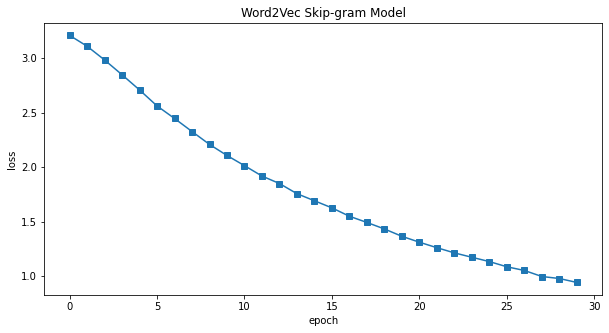

In [19]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

### Load model .h5:

In [31]:
!cd "/content/gdrive/My Drive/NLP/Part2/D015_推論方法的詞向量_實作加速版 word2vec_作業檔"
!pwd
model = torch.load('d15_trained_weights.h5')
print(model.h)

/content/gdrive/My Drive/NLP/Part2/D015_推論方法的詞向量_實作加速版 word2vec_作業檔


AttributeError: ignored

### Test:

In [26]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

In [27]:
get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.401: throwing.
cosine sim=0.371: qualified.
cosine sim=0.371: gandhi.
cosine sim=0.360: mind.


In [28]:
get_similarity('sure', 4, model, word2idx, idx2word)

cosine sim=0.454: what.
cosine sim=0.403: offsetting.
cosine sim=0.397: reality.
cosine sim=0.396: mind.
